In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the curre nt kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/prep_grid_aste_90.py"

(450, 90)
RAC2d (40500,)
(100,)


## load the snapshot first to prove this

In [2]:
# we need to load the miniaste

dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirbudg = layers_path + "diags/BUDG/"
dirdiags = dirbudg
dirstate = layers_path + "diags/STATE/"
dirlayers = layers_path + "diags/LAYERS/"
dirtrsp = layers_path + "diags/TRSP/"

In [3]:
layers_path

'/scratch3/atnguyen/aste_90x150x60/run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/'

In [4]:
# try to use rdmds
fileprefix = "/scratch3/atnguyen/aste_90x150x60/"
extBasin='run_template/input_maskTransport/'
filename = fileprefix + extBasin + "GATE_transports_v2_mskBasin.bin"
ind = np.fromfile(filename, dtype=np.int32)  # auto-reads .meta for shape/dtype/order
orig_shape = (ind.shape)

ind2d = ind.reshape(ny,nx)

mymsk = np.full((ny,nx),np.nan)
mymsk[ind2d == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

ind = ind.reshape(ny,nx)
mymsk = np.full((ny,nx),np.nan)
mymsk[ind == 57408.0] = 1

# make this smaller
mymsk[:,27:50] = np.nan
mymsk[:160,12:30] = np.nan
mymsk[160:163,15:30] = np.nan

In [5]:
# we will select a SINGLE cell and do the budget for this cell

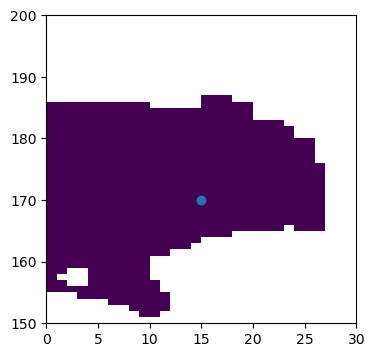

In [35]:
fig = plt.figure(figsize=(4,4))

plt.pcolormesh(mymsk)
plt.ylim(150,200)
plt.xlim(0,30)

# pick a random point
ix = 15
iy = 170
iz = 1  # surface point
iz = 0 # here we will rerun at 10 for sample_2_3
plt.scatter(ix,iy)

In [36]:
# load the ADV terms for the Barents Sea for this singular box -- single box will all be contributing the same
# to the same T or S bin, so these will be the same when plotted in T or S space
# but we can show this anyways
tsstr = np.array(["0000000002","0000000003"])
t2 = int(tsstr[1]) # for the offline version

In [37]:
t2 = int(tsstr[1])
# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [38]:
THETA[iz,iy,ix]

-0.4999777674674988

In [39]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
UVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
VVELMASS,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[3])

# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["ADVr_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)

hf = mygrid['hFacC']

ADV_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(ADVx_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(ADVy_TH.reshape(nz, ny, nx), nfx, nfy))
ADV_hconv = ADV_hconv #* hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
ADVhT = ADV_hconv

trWtopADV = -(ADVr_TH)

ADVrT = np.zeros((nz,ny,nx),dtype=float)
ADVrT[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])  # this is not the way we did it in the original code but this is the way An has done it so we try

In [40]:
# calculate the other terms in the eqn for budget

# load the other terms from the offline version -- we can just put this on top of the T diagram

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

DF_hconv = calc_UV_conv_mod(nfx, nfy,get_aste_faces(DFxE_TH.reshape(nz, ny, nx), nfx, nfy),get_aste_faces(DFyE_TH.reshape(nz, ny, nx), nfx, nfy))
DF_hconv = DF_hconv * hf   # degC·m^3/s at cell centers (matches: ff.DFh = ff.DFh .* hf)
DFhT = DF_hconv

trWtopDF = -(DFrE_TH+DFrI_TH)

DFrT = np.zeros((nz,ny,nx),dtype=float)
DFrT[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])

# to get the surface term, we need J/s and convert to degC.m^3/s
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# we need to create zconv_top and swtop
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,np.zeros((nz,ny,nx)))*mk3D_mod(RAC*oceQsw,np.zeros((nz,ny,nx)))   # J/s

# zconvtop_heat is here
zconv_top_heat = TFLUX * RAC     # W/m^2 * m^2 = J/s


def surface_contrib_JT(zconv_top_heat, swtop, rcp, fill_last=0.0):
    """
    zconv_top_heat: (ny, nx)
    swtop:          (nz, ny, nx)
    rcp:            scalar
    fill_last:      value for bottom slice (k = nz-1), usually 0.0 or np.nan
    returns:
      JsurfT:       (nz, ny, nx)  # Sv / PSU
    """
    nz, ny, nx = swtop.shape

    eT = zconv_top_heat.reshape(1, ny, nx)  # (1,ny,nx) for broadcast

    J = np.empty_like(swtop, dtype=float)

    # k = 0: (eT - fT[1]) / rcp / dT / dS * 1e-6
    J[0] = (eT[0] - swtop[1]) / rcp if np.ndim(binwidthT)==0 else \
           (eT[0] - swtop[1]) / rcp

    # 1 .. nz-2: -(fT[k+1]-fT[k]) / rcp / dT / dS * 1e-6
    J[1:nz-1] = -(swtop[2:nz] - swtop[1:nz-1]) / rcp

    # bottom slice (k = nz-1): no k+1; choose your boundary convention
    J[-1] = fill_last
    return J

Ft_surftest = surface_contrib_JT(zconv_top_heat,swtop,myparms['rcp'])    # this is in degC.m^3/s

# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# do the vertical convergence for KPP
trWtopKPP = -(KPPg_TH)         # degC.m^3/s

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]


# load the tend from the get_Jterms and plot this
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirdiags, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

dt = 1800

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/
AB_gT = 0
tmptend=(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # degC.m/s * m^2 = degC.m^3/s
tmptend = tmptend                          # degC.m^3/s

(150.0, 180.0)

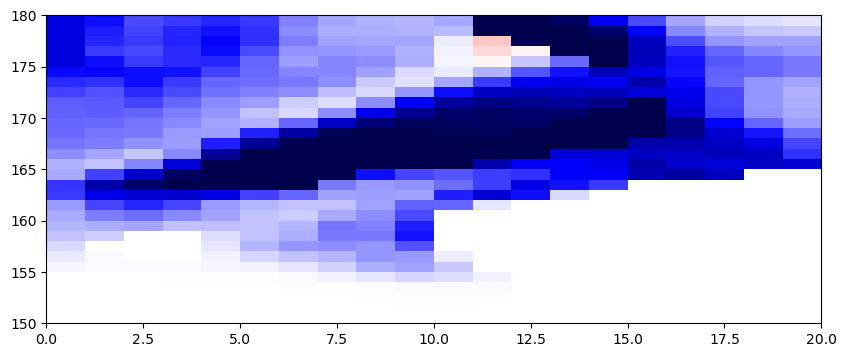

In [41]:
plt.pcolormesh(Ft_surftest[0] * mymsk,vmin=-1e5,vmax=1e5,cmap='seismic')# * mymsk)
plt.xlim(0,20)
plt.ylim(150,180)

In [42]:
# load the TS bins
# also load the bins again so we have them locally
boundsT = np.round(np.squeeze(rdmds(layers_path + "layers2TH")).ravel(),1)
nT = boundsT.size - 1
boundsS = np.round(np.squeeze(rdmds(layers_path + "layers1SLT")).ravel(),1)
nS = boundsS.size - 1
binwidthT = boundsT[1:] - boundsT[:-1]
binwidthS = boundsS[1:] - boundsS[:-1]
binwidthT1 = 0.5 * (binwidthT[1:] + binwidthT[:-1])  # normalize by these
binwidthS1 = 0.5 * (binwidthS[1:] + binwidthS[:-1])
binmidT = (boundsT[1:] + boundsT[:-1]) /2    # bin to these
binmidS = (boundsS[1:] + boundsS[:-1]) /2
nT = nT
nS = nS
nTm1 = nT-1
nSm1 = nS-1

In [43]:
# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[iz,iy,ix] = 1  # set the single point to mymsk3d

# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((7, nT-1))
dF_Tnew = np.zeros((7, nT-1))
Lijnew = np.zeros((7, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
        dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
        dF_Tnew[4, i] = np.nansum(surf_flat[ij])
        dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
        dF_Tnew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]


In [44]:
dF_Tnew[6][8]

0.0

In [45]:
# do this for the whole Barents Sea to see if we replicated the correct thing

labels = np.array(["ADVh","ADVr","DFh","DFr","surf","kpp","tend"])

s = 0 
# print("gates       ",np.nansum(np.nansum(Msum,axis=0))/np.nansum(binwidthT1),"m^3/s")
for i in range(6):
    at = np.nansum(dF_Tnew[i]) / np.nansum(binwidthT1)
    print(labels[i],"       ",at,"m^3/s")
    s += at
print()
print("total volume tend RHS: ",s,"m^3/s")
print("total volume tend LHS: ",np.nansum(dF_Tnew[-1]) / np.nansum(binwidthT1),"m^3/s")

ADVh         952.3854944062675 m^3/s
ADVr         -19.182354291667927 m^3/s
DFh         -4.182134899731343 m^3/s
DFr         2542.8506853795566 m^3/s
surf         -2671.862990649994 m^3/s
kpp         526.7607119631222 m^3/s

total volume tend RHS:  1326.7694119075527 m^3/s
total volume tend LHS:  1326.7694119075086 m^3/s


In [46]:
# ok now get the T and S bin for that specific point
THETApt = THETA[iz,iy,ix]
SALTpt = SALT[iz,iy,ix]

ijT = np.where((THETApt >= binmidT[i]) & (THETApt < binmidT[i + 1]))[0]
ijS = np.where((SALTpt >= binmidS[i]) & (SALTpt < binmidS[i + 1]))[0]


In [47]:
# this is the index in binsmidT for this
boundsT.flatten()[1:-1][np.where(dF_Tnew[0]>0)]

array([-0.6])

In [48]:
THETA[iz,iy,ix]

-0.4999777674674988

In [49]:
boundsT.flatten()[1:-1][6:10]

array([-0.2,  0.2,  0.6,  1. ])

In [50]:
mywidT = binwidthT1[8]  # this is the binwidth we divide by in this example
mywidT

0.4

In [51]:
ADVr_TH[:,iy,ix]

array([     0.        ,   -802.78152711,  -1133.26679953,   -671.32610525,
          305.7552906 ,   1526.80629111,   2800.69761542,   3976.99721354,
         4958.52015922,   5700.64089801,   6181.89083056,   6383.43155063,
         6273.80066854,   5752.32913337,   4516.716366  ,   1806.24813905,
        -3896.54814135, -14199.69655942, -25090.27200153, -23195.23658137,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ])

In [52]:
ADVrT[:,iy,ix]

array([  -802.78152711,   -330.48527243,    461.94069429,    977.08139585,
         1221.05100051,   1273.89132431,   1176.29959811,    981.52294568,
          742.12073879,    481.24993255,    201.54072007,   -109.63088209,
         -521.47153517,  -1235.61276737,  -2710.46822695,  -5702.7962804 ,
       -10303.14841807, -10890.57544211,   1895.03542016,  23195.23658137,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ,      0.        ,      0.        ,
            0.        ,      0.        ])

In [53]:
# now calculate the 5 gates (ie one is the surface)
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
ADVr_TH = ADVr_TH.reshape((nz,ny,nx))
M1 = ADVx_TH[iz,iy,ix]     # south gate
M2 = -ADVx_TH[iz,iy,ix+1]  # north gate
M3 = ADVy_TH[iz,iy,ix]     # east gate in
M4 = -ADVy_TH[iz,iy+1,ix]  # west gate in
Mb = ADVr_TH[iz+1,iy,ix]   # bottom gate in
Mt = -ADVr_TH[iz,iy,ix]    # top gate down

In [54]:
M1
M2
# mywidT

35182.085946285675

In [55]:
print(M4)

52231.47107955432


In [56]:
iMt = [np.where(dF_Tnew[0]!=0)]
M_T_offline_new = np.zeros((7, nT-1))  # include one for sum of bins
M_T_offline_new[0,iMt] = M1 / mywidT  # becomes m^3/s
M_T_offline_new[1,iMt] = M2 / mywidT  # becomes m^3/s
M_T_offline_new[2,iMt] = M3 / mywidT  # becomes m^3/s
M_T_offline_new[3,iMt] = M4 / mywidT  # becomes m^3/s
M_T_offline_new[4,iMt] = Mb / mywidT  # becomes m^3/s
M_T_offline_new[5,iMt] = (M1+M2+M3+M4) / mywidT  # becomes m^3/s
M_T_offline_new[6,iMt] = Mt / mywidT
labels_M = np.array(["S","N","E","W","Bot","allH","Top"])

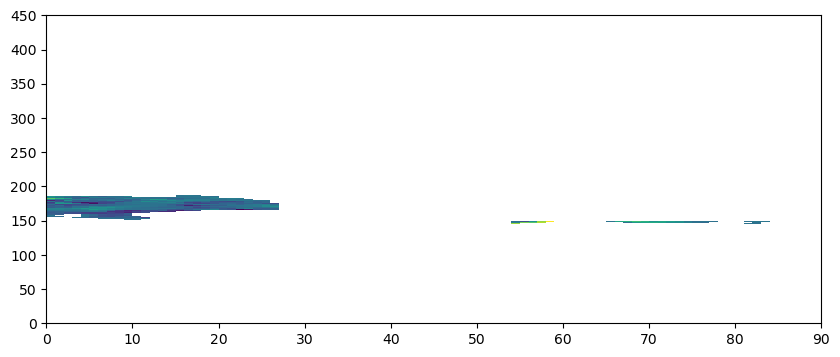

In [57]:
plt.pcolormesh(ADVx_TH[0] * mymsk)

In [58]:
labels_M = np.array(["E","W","S","N","b","sigmaM","t"])
G_T_offline_new.shape

(7, 111)

ADVh
ADVr
DFh
DFr
surf
kpp

E
W
S
N
b
sigmaM


Text(0, 0.5, 'm^3/s')

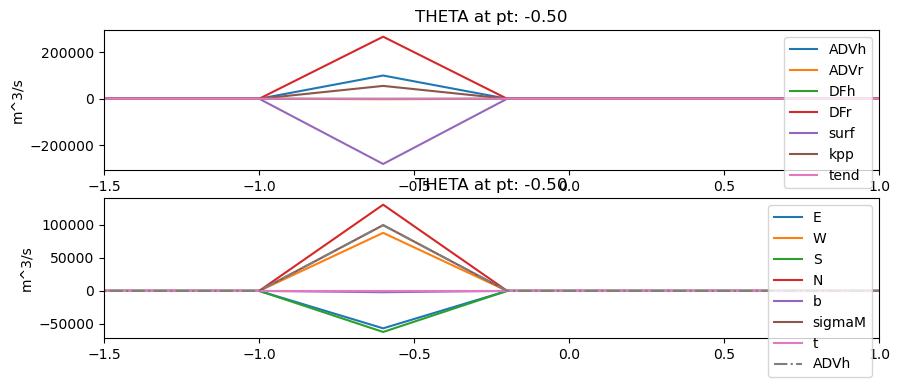

In [64]:
fig = plt.figure()

ax = plt.subplot(211)
for i in range(6):
    if np.nansum(G_T_offline_new[i]!=0):
        print(labels[i])
    ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[i],label = labels[i])


# plot the overall values
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[6]/2.13e3,label = labels[6])


ax.legend()
ax.set_xlim(-1.5,1)
ax.set_title(f"THETA at pt: {THETA[iz,iy,ix]:.2f}")
ax.set_ylabel("m^3/s")
# ax.set_ylim(-100,1000)
print()

ax = plt.subplot(212)
for i in range(7):
    if np.nansum(M_T_offline_new[i]!=0):
        print(labels_M[i])
    ax.plot(boundsT.flatten()[1:-1],M_T_offline_new[i],label = labels_M[i])

# add the ADVh to this to compare
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-.")
ax.legend()
ax.set_xlim(-1.5,1)
ax.set_title(f"THETA at pt: {THETA[iz,iy,ix]:.2f}")
ax.set_ylabel("m^3/s")


In [68]:
print(iz,iy,ix)

0 170 15


In [74]:
THETA[iz,iy,ix]

-0.4999777674674988

In [77]:
ADVhT[iz,iy,ix]

39857.33294090229

In [67]:
for term in range(dF_Tnew.shape[0]):
    print(dF_Tnew[term][5])

39857.33294090229
-802.7815271063026
-175.02234555375668
106418.30118313442
-111817.46615870224
22044.93579565666
55525.299888329224


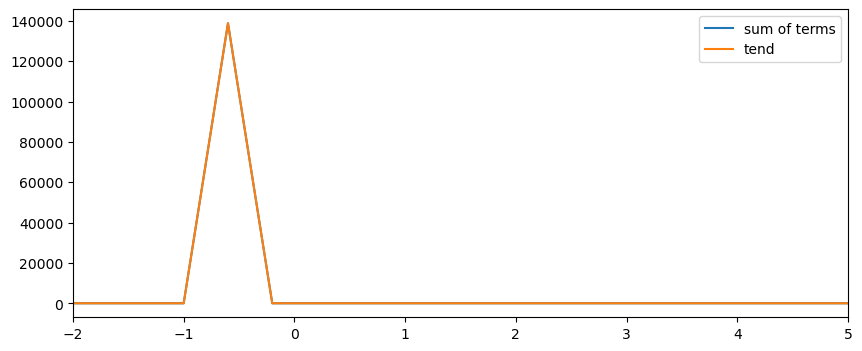

In [78]:
## plot the overall sum compared to the tend
dt = 1800

fig = plt.figure()

ax = plt.subplot(111)

ax.plot(boundsT.flatten()[1:-1],np.nansum(G_T_offline_new[:-1],axis=0),label = "sum of terms")
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[-1],label = "tend")

ax.set_xlim(-2,5)
ax.legend()

In [79]:
np.nansum(dF_Tnew[:-1])

55525.29988833107

In [80]:
# labels_M = np.array(["S","N","E","W","K=1","ΣM"])

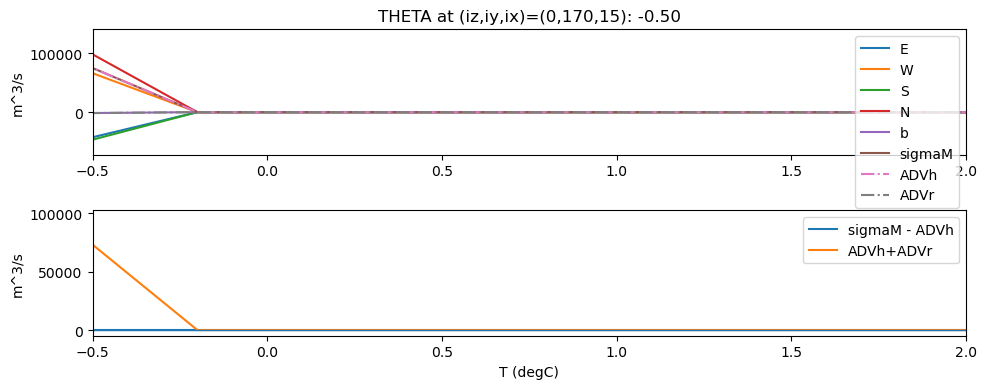

In [81]:
fig = plt.figure()

x = boundsT.flatten()[1:-1]
ADVh = G_T_offline_new[0]  # assuming index 0 is ADVh
ADVr = G_T_offline_new[1]

# --- Top: keep only the second plot (H terms + ADVh overlay) ---
ax = plt.subplot(211)
for i in range(6):
    ax.plot(x, M_T_offline_new[i], label=labels_M[i])

ax.plot(x, ADVh, label=labels[0], linestyle="-.")  # ADVh overlay
ax.plot(x, ADVr, label="ADVr", linestyle="-.")  # ADVh overlay

ax.legend()
ax.set_xlim(-0.5, 2)
theta_pt = THETA[iz, iy, ix]
ax.set_title(f"THETA at (iz,iy,ix)=({iz},{iy},{ix}): {theta_pt:.2f}")
ax.set_ylabel("m^3/s")

# --- Bottom: residuals (H - ADVh) ---
ax = plt.subplot(212, sharex=ax)
ax.plot(x, M_T_offline_new[-2] - ADVh , label=f"{labels_M[i]} - {labels[0]}")
ax.plot(x, ADVh + ADVr, label="ADVh+ADVr")



ax.axhline(0, linewidth=1)
ax.legend()
ax.set_xlim(-0.5, 2)
# ax.set_ylim(-1e-14,1e-14)
ax.set_ylabel("m^3/s")
ax.set_xlabel("T (degC)")

plt.tight_layout()


In [82]:
np.nansum(M_T_offline_new[-2])

99643.33235225572

In [83]:
np.nansum(ADVh)

99643.33235225572

In [84]:
binwidthT1

array([0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 ,
       0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 ,
       0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 ,
       0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 ,
       0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 ,
       0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 ,
       0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 ,
       0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 ,
       0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 ,
       0.4 , 0.3 , 0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.45, 0.5 , 0.5 , 0.5 ,
       0.5 ])

In [85]:
ADVhT[iz,iy,ix]/.4

99643.33235225572

In [86]:
print(M1,M2,M3,M4)
print((M1+M2+M3+M4)/.4)

-22675.063506827188 35182.085946285675 -24881.160578110517 52231.47107955432
99643.33235225572


## do the whole column for this

In [87]:
# change this to the whole column

# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[:,iy,ix] = 1  # set the single point to mymsk3d

# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((7, nT-1))
dF_Tnew = np.zeros((7, nT-1))
Lijnew = np.zeros((7, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
        dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
        dF_Tnew[4, i] = np.nansum(surf_flat[ij])
        dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
        dF_Tnew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

In [88]:
ADVx_TH = ADVx_TH.reshape((nz, ny, nx))
ADVy_TH = ADVy_TH.reshape((nz, ny, nx))
ADVr_TH = ADVr_TH.reshape((nz, ny, nx))

# allocate 3D "gate fields" (nan everywhere except the gate)
M1T = np.full((nz, ny, nx), np.nan, dtype=float)  # south gate
M2T = np.full((nz, ny, nx), np.nan, dtype=float)  # north gate
M3T = np.full((nz, ny, nx), np.nan, dtype=float)  # east gate in
M4T = np.full((nz, ny, nx), np.nan, dtype=float)  # west gate in

# fill only the gate line(s)
M1T[:, iy, ix]   =  ADVx_TH[:, iy, ix]      # south gate
M2T[:, iy, ix] = -ADVx_TH[:, iy, ix+1]    # north gate
M3T[:, iy, ix]   =  ADVy_TH[:, iy, ix]      # east gate in
M4T[:, iy, ix] = -ADVy_TH[:, iy+1, ix]    # west gate in

In [89]:
def _bincount_sum_with_nan(idx, vals, nout):
    """
    NaN-aware per-bin sum:
    if *all* entries in a bin are NaN, that bin returns NaN;
    otherwise NaNs are ignored and finite values are summed.
    """
    # track counts of non-nan contributions
    finite = np.isfinite(vals)
    sums   = np.bincount(idx[finite], vals[finite], minlength=nout).astype(float)
    counts = np.bincount(idx[finite], None, minlength=nout).astype(float)
    out = sums
    out[counts == 0] = np.nan
    return out

# define a function to turn the gates as 3D into 1D for T and S
def gateway3D(ADV_west,ADV_FJNZ,ADV_SPFJ,ADV_NZRU,tracer,binmidTracer,nTm1):
    tracer_flat = tracer.ravel()
    bin_idx_mid = np.digitize(tracer_flat, binmidTracer, right=False) - 1
    valid_mid   = (bin_idx_mid >= 0) & (bin_idx_mid < nTm1) & np.isfinite(tracer_flat)
    idx_mid     = bin_idx_mid[valid_mid]

    # flatten these so we can bin
    ADV_west_flat   = ADV_west.ravel()
    ADV_fjnz_flat   = ADV_FJNZ.ravel()
    ADV_spfj_flat   = ADV_SPFJ.ravel()
    ADV_nzru_flat   = ADV_NZRU.ravel()

    # per-bin sums with NaN-propagation
    ADVh_BSO = _bincount_sum_with_nan(idx_mid, ADV_west_flat[valid_mid], nTm1)
    ADVh_FJNZ = _bincount_sum_with_nan(idx_mid, ADV_fjnz_flat[valid_mid], nTm1)
    ADVh_SPFJ = _bincount_sum_with_nan(idx_mid, ADV_spfj_flat[valid_mid], nTm1)
    ADVh_NZRU = _bincount_sum_with_nan(idx_mid, ADV_nzru_flat[valid_mid], nTm1)
    
    # edge-based G (m^3/s): divide by edge binwidths
    G_BSO = ADVh_BSO #/ binwidthT1
    G_FJNZ = ADVh_FJNZ #/ binwidthT1
    G_SPFJ = ADVh_SPFJ #/ binwidthT1
    G_NZRU = ADVh_NZRU #/ binwidthT1

    return G_BSO,G_FJNZ,G_SPFJ,G_NZRU

In [90]:
nTm1 = nT-1
G_S,G_N,G_E,G_W = gateway3D(M1T,M2T,M3T,M4T,THETA,binmidT,nTm1)  # in tracer.m^3/s
G_S[np.isnan(G_S)] = 0
G_N[np.isnan(G_N)] = 0
G_W[np.isnan(G_W)] = 0
G_E[np.isnan(G_E)] = 0

In [91]:
ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
G_S_sum = np.nansum(G_S) / np.nansum(binwidthT1)
G_N_sum = np.nansum(G_N) / np.nansum(binwidthT1)
G_E_sum = np.nansum(G_E) / np.nansum(binwidthT1)
G_W_sum = np.nansum(G_W) / np.nansum(binwidthT1)

print("ADVhT:",ADVhsum,"m^3/s")
print("gates sum:",G_S_sum+G_N_sum+ G_E_sum+ G_W_sum,"m^3/s")

ADVhT: 6485.482818144116 m^3/s
gates sum: 6485.482818144116 m^3/s


In [92]:
labels_G = np.array(["S","N","E","W","ΣM"])

Text(0, 0.5, 'm^3/s')

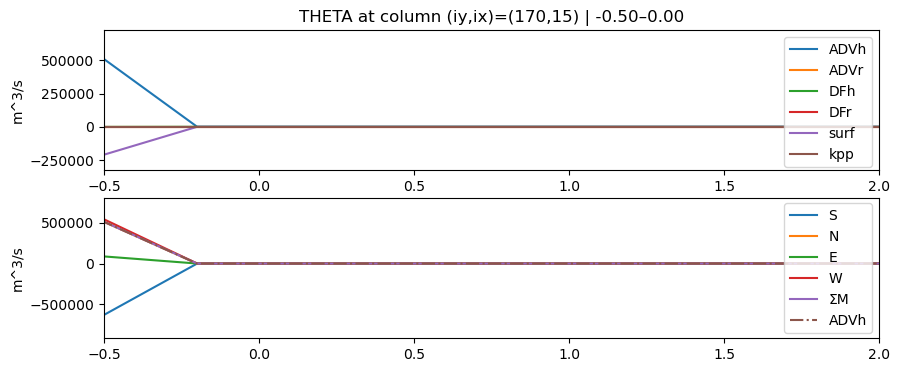

In [93]:
fig = plt.figure()

ax = plt.subplot(211)
for i in range(6):
    ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[i],label = labels[i])

ax.legend()
ax.set_xlim(-.5,2)
v = THETA[:, iy, ix]  # column (nz,)
ax.set_title(
    f"THETA at column (iy,ix)=({iy},{ix}) | "
    f"{np.nanmin(v):.2f}–{np.nanmax(v):.2f}"
)
ax.set_ylabel("m^3/s")


ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1],G_S/binwidthT1,label = labels_G[0])
ax.plot(boundsT.flatten()[1:-1],G_N/binwidthT1,label = labels_G[1])
ax.plot(boundsT.flatten()[1:-1],G_E/binwidthT1,label = labels_G[2])
ax.plot(boundsT.flatten()[1:-1],G_W/binwidthT1,label = labels_G[3])

ax.plot(boundsT.flatten()[1:-1],(G_S+G_W+G_E+G_N)/binwidthT1,label = labels_G[4])


# add the ADVh to this to compare
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-.")
ax.legend(loc="right")
ax.set_xlim(-.5,2)
# ax.set_title(f"THETA at pt: {np.nanmin(v):.2f}–{np.nanmax(v):.2f}")
ax.set_ylabel("m^3/s")


In [94]:
np.where(mygrid['hFacC'][:,iy,ix] == 1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),)

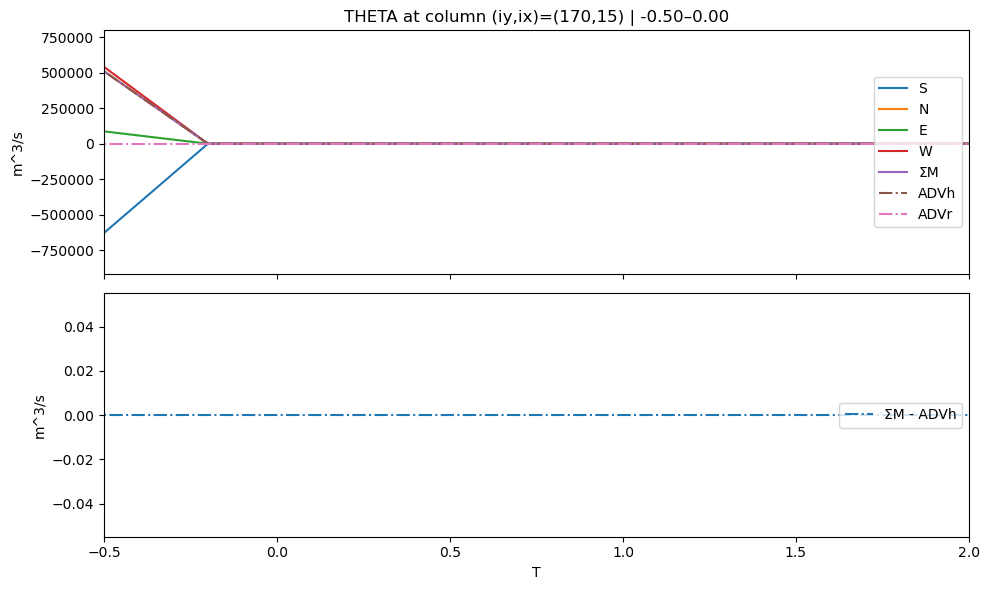

In [95]:
# plot just the ADVh term and the residual

fig = plt.figure(figsize=(10, 6))
x = boundsT.flatten()[1:-1]

ax1 = plt.subplot(211)
v = THETA[:, iy, ix]  # column (nz,)
ax1.set_title(
    f"THETA at column (iy,ix)=({iy},{ix}) | "
    f"{np.nanmin(v):.2f}–{np.nanmax(v):.2f}"
)

ax1.plot(x, G_S/binwidthT1, label=labels_G[0])
ax1.plot(x, G_N/binwidthT1, label=labels_G[1])
ax1.plot(x, G_E/binwidthT1, label=labels_G[2])
ax1.plot(x, G_W/binwidthT1, label=labels_G[3])
ax1.plot(x, (G_S+G_W+G_E+G_N)/binwidthT1, label=labels_G[4])

# add the ADVh to this to compare
ax1.plot(x, G_T_offline_new[0], label=labels[0], linestyle="-.")

ax1.plot(x, G_T_offline_new[1], label="ADVr", linestyle="-.")

ax1.legend(loc="right")
ax1.set_xlim(-0.5, 2)
ax1.set_ylabel("m^3/s")
ax1.tick_params(labelbottom=False)  # hide x tick labels on top subplot

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(x, (G_S+G_W+G_E+G_N)/binwidthT1 - G_T_offline_new[0],
         label="ΣM - ADVh", linestyle="-.")
ax2.legend(loc="right")
ax2.set_xlim(-0.5, 2)
ax2.set_ylabel("m^3/s")
ax2.set_xlabel("T")

plt.tight_layout()


## change the following to 2x2 -- will not work but we can try

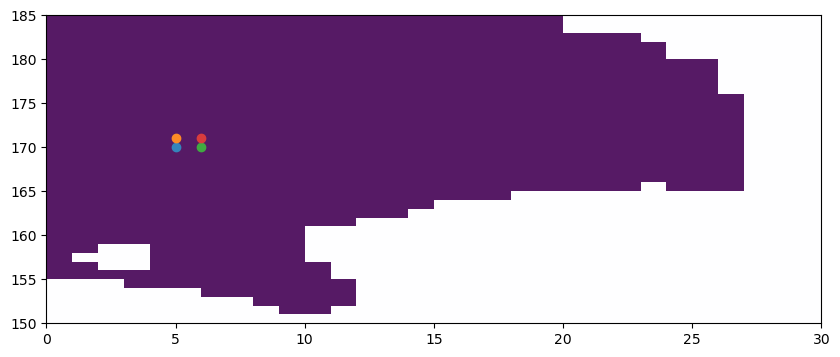

In [531]:
# this works, now we expand to a 2x2
# why does this work? ADVh is contributing to the same T bins as the previous

plt.pcolormesh(mymsk)
plt.ylim(150,185)
plt.xlim(0,30)

# pick a random point
ix,ixp1 = 5,6
iy,iyp1 = 170,171
iz = 0  # surface point
plt.scatter(ix,iy)
plt.scatter(ix,iyp1)
plt.scatter(ixp1,iy)
plt.scatter(ixp1,iyp1)
plt.pcolormesh(mymsk3d[0],cmap="Blues",alpha=0.1)

In [532]:
# change this to the whole column

# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[:,iy,ix] = 1  # set the single point to mymsk3d
mymsk3d[:,iyp1,ix] = 1
mymsk3d[:,iy,ixp1] = 1
mymsk3d[:,iyp1,ixp1] = 1


# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((7, nT-1))
dF_Tnew = np.zeros((7, nT-1))
Lijnew = np.zeros((7, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
        dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
        dF_Tnew[4, i] = np.nansum(surf_flat[ij])
        dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
        dF_Tnew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

In [533]:
# great, now we get the gates again
# allocate 3D "gate fields" (nan everywhere except the gate)
M1T = np.full((nz, ny, nx), 0, dtype=float)  # south gate
M2T = np.full((nz, ny, nx), 0, dtype=float)  # north gate
M3T = np.full((nz, ny, nx), 0, dtype=float)  # east gate in
M4T = np.full((nz, ny, nx), 0, dtype=float)  # west gate in

# the below makes no sense, write out what we want to read from
ys,xs = np.array([iy,iy]),np.array([ix,ix+1])
M1T[:,ys,xs] += ADVy_TH[:, ys, xs]

yn,xn = np.array([iyp1+1,iyp1+1]),np.array([ix,ix+1])
M2T[:,yn-1,xn] -= ADVy_TH[:, yn, xn]

yw,xw = np.array([iy,iyp1]),np.array([ix,ix])
M3T[:,yw,xw] += ADVx_TH[:,yw,xw]

ye,xe = np.array([iy,iyp1]),np.array([ixp1+1,ixp1+1])
M4T[:,ye,xe-1] -= ADVx_TH[:,ye,xe]

In [534]:
G_S,G_N,G_E,G_W = gateway3D(M1T,M2T,M3T,M4T,THETA,binmidT,nTm1)  # in tracer.m^3/s
G_S[np.isnan(G_S)] = 0
G_N[np.isnan(G_N)] = 0
G_W[np.isnan(G_W)] = 0
G_E[np.isnan(G_E)] = 0

In [535]:
ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
G_S_sum = np.nansum(G_S) / np.nansum(binwidthT1)
G_N_sum = np.nansum(G_N) / np.nansum(binwidthT1)
G_E_sum = np.nansum(G_E) / np.nansum(binwidthT1)
G_W_sum = np.nansum(G_W) / np.nansum(binwidthT1)

print("ADVhT:",ADVhsum,"m^3/s")
print("gates sum:",G_S_sum+G_N_sum+ G_E_sum+ G_W_sum,"m^3/s")

ADVhT: 1377.7059356243637 m^3/s
gates sum: 1377.7059356243635 m^3/s


In [536]:
labels_G = np.array(["S","N","E","W","ΣM"])

Text(0, 0.5, 'm^3/s')

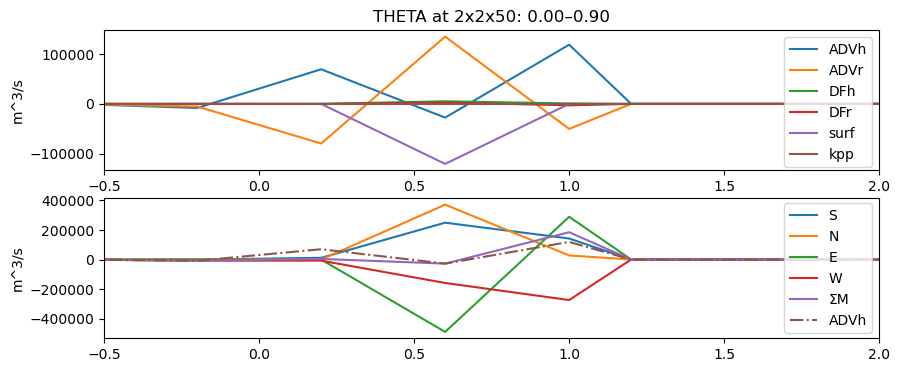

In [537]:
fig = plt.figure()

ax = plt.subplot(211)
for i in range(6):
    ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[i],label = labels[i])

ax.legend()
ax.set_xlim(-.5,2)
v = THETA[:, iy, ix]  # column (nz,)
ax.set_title(f"THETA at 2x2x50: {np.nanmin(v):.2f}–{np.nanmax(v):.2f}")
ax.set_ylabel("m^3/s")


ax = plt.subplot(212)
ax.plot(boundsT.flatten()[1:-1],G_S/binwidthT1,label = labels_G[0])
ax.plot(boundsT.flatten()[1:-1],G_N/binwidthT1,label = labels_G[1])
ax.plot(boundsT.flatten()[1:-1],G_E/binwidthT1,label = labels_G[2])
ax.plot(boundsT.flatten()[1:-1],G_W/binwidthT1,label = labels_G[3])

ax.plot(boundsT.flatten()[1:-1],(G_S+G_W+G_E+G_N)/binwidthT1,label = labels_G[4])


# add the ADVh to this to compare
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-.")
ax.legend(loc="right")
ax.set_xlim(-.5,2)
# ax.set_title(f"THETA at pt: {np.nanmin(v):.2f}–{np.nanmax(v):.2f}")
ax.set_ylabel("m^3/s")


In [447]:
for i in range(4,12):
    print(G_T_offline_new[0][i],((G_S+G_W+G_E+G_N)/binwidthT1)[i])

print()
print(boundsT.flatten()[6:10])

0.0 0.0
0.0 0.0
-8164.451947626937 -8164.451947626937
69628.08287502157 4019.3229795721845
-27601.26025959188 -27702.099167854176
119062.98818650158 184772.5869902133
0.0 0.0
0.0 0.0

[-0.6 -0.2  0.2  0.6]


In [448]:
# ok so this is "breaking" somewhere near T = 0

In [449]:
# what if we implement an arbitrary cutoff at z=10 and add the vertical component

In [450]:
# make a plot of theta vs depth index here
# THETA_flat = 

In [451]:
mymsk3d[mymsk3d ==0] = np.nan
A = THETA * mymsk3d * mygrid['hFacC']
inds = np.where((A > -0.2) & (A < 0.2))   # tuple of (iz, iy, ix)
print(inds)
inds = np.where((A > 0.2) & (A < 0.6))   # tuple of (iz, iy, ix)
print(inds)

(array([19]), array([170]), array([6]))
(array([17, 18, 18]), array([170, 170, 170]), array([6, 5, 6]))


In [452]:
# THETA

In [453]:
np.where(mygrid['hFacC']*mymsk3d>0)

(array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16,
        17, 17, 17, 17, 18, 18, 18, 19]),
 array([170, 170, 171, 171, 170, 170, 171, 171, 170, 170, 171, 171, 170,
        170, 171, 171, 170, 170, 171, 171, 170, 170, 171, 171, 170, 170,
        171, 171, 170, 170, 171, 171, 170, 170, 171, 171, 170, 170, 171,
        171, 170, 170, 171, 171, 170, 170, 171, 171, 170, 170, 171, 171,
        170, 170, 171, 171, 170, 170, 171, 171, 170, 170, 171, 171, 170,
        170, 171, 171, 170, 170, 171, 171, 170, 170, 171, 170]),
 array([5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6,
        5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6,
        5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6,
  

In [454]:
# I am increasingly thinking something is going wrong at the seafloor

In [494]:
# add a cutoff at z = 10 and try the same box with a bottom "gate" in
izmax = 20

In [495]:
# change this to the whole column

# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[:izmax,iy,ix] = 1  # set the single point to mymsk3d
mymsk3d[:izmax,iyp1,ix] = 1
mymsk3d[:izmax,iy,ixp1] = 1
mymsk3d[:izmax,iyp1,ixp1] = 1


# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((7, nT-1))
dF_Tnew = np.zeros((7, nT-1))
Lijnew = np.zeros((7, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
        dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
        dF_Tnew[4, i] = np.nansum(surf_flat[ij])
        dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
        dF_Tnew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

In [496]:
# now do the gates one more time

# great, now we get the gates again
# allocate 3D "gate fields" (nan everywhere except the gate)
M1T = np.full((nz, ny, nx), 0, dtype=float)  # south gate
M2T = np.full((nz, ny, nx), 0, dtype=float)  # north gate
M3T = np.full((nz, ny, nx), 0, dtype=float)  # east gate in
M4T = np.full((nz, ny, nx), 0, dtype=float)  # west gate in
MBT = np.full((nz, ny, nx), 0, dtype=float)  # bottom gate in -- should be of shape 2x2 and binned to those four values


# the below makes no sense, write out what we want to read from
ys,xs = np.array([iy,iy]),np.array([ix,ix+1])
M1T[:izmax,ys,xs] += ADVy_TH[:izmax, ys, xs]

yn,xn = np.array([iyp1+1,iyp1+1]),np.array([ix,ix+1])
M2T[:izmax,yn-1,xn] -= ADVy_TH[:izmax, yn, xn]

yw,xw = np.array([iy,iyp1]),np.array([ix,ix])
M3T[:izmax,yw,xw] += ADVx_TH[:izmax,yw,xw]

ye,xe = np.array([iy,iyp1]),np.array([ixp1+1,ixp1+1])
M4T[:izmax,ye,xe-1] -= ADVx_TH[:izmax,ye,xe]

# we need to make one more gate which conains -ADVr_TH (not sure sign)
ybot,xbot = np.array([iy,iy,iyp1,iyp1]),np.array([ix,ixp1,ix,ixp1])
for j,i in zip(ybot,xbot):
    MBT[izmax-1,j,i] -= ADVr_TH[izmax,j,i]

In [497]:
G_S,G_N,G_E,G_W = gateway3D(M1T,M2T,M3T,M4T,THETA,binmidT,nTm1)  # in tracer.m^3/s
G_S[np.isnan(G_S)] = 0
G_N[np.isnan(G_N)] = 0
G_W[np.isnan(G_W)] = 0
G_E[np.isnan(G_E)] = 0

In [498]:
ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
G_S_sum = np.nansum(G_S) / np.nansum(binwidthT1)
G_N_sum = np.nansum(G_N) / np.nansum(binwidthT1)
G_E_sum = np.nansum(G_E) / np.nansum(binwidthT1)
G_W_sum = np.nansum(G_W) / np.nansum(binwidthT1)
print("ADVhT:",ADVhsum,"m^3/s")
print("gates sum:",G_S_sum+G_N_sum+ G_E_sum+ G_W_sum,"m^3/s")

# so these are the same

ADVhT: 1377.7059356243637 m^3/s
gates sum: 1377.7059356243635 m^3/s


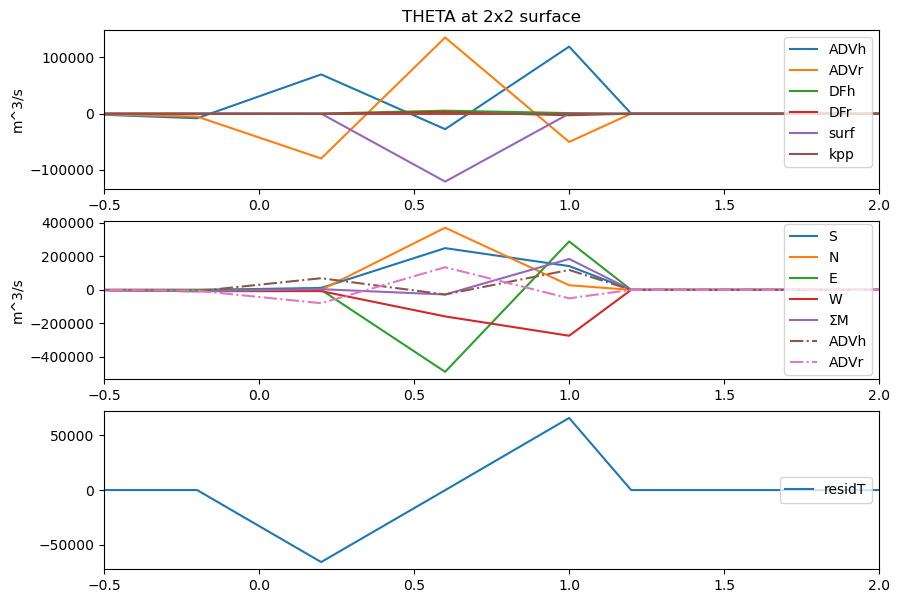

In [499]:
fig = plt.figure(figsize = (10,7))

ax = plt.subplot(311)
for i in range(6):
    ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[i],label = labels[i])

ax.legend()
ax.set_xlim(-.5,2)
v = THETA[:, iy, ix]  # column (nz,)
ax.set_title("THETA at 2x2 surface")
ax.set_ylabel("m^3/s")


ax = plt.subplot(312)
ax.plot(boundsT.flatten()[1:-1],G_S/binwidthT1,label = labels_G[0])
ax.plot(boundsT.flatten()[1:-1],G_N/binwidthT1,label = labels_G[1])
ax.plot(boundsT.flatten()[1:-1],G_E/binwidthT1,label = labels_G[2])
ax.plot(boundsT.flatten()[1:-1],G_W/binwidthT1,label = labels_G[3])

ax.plot(boundsT.flatten()[1:-1],(G_S+G_W+G_E+G_N)/binwidthT1,label = labels_G[4])


# add the ADVh to this to compare
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-.")
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[1],label = labels[1],linestyle = "-.")

# ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0]+G_T_offline_new[1],label = "ADVr+ADVh",linestyle = "-.")

ax.legend(loc="right")
ax.set_xlim(-.5,2)
# ax.set_title(f"THETA at pt: {np.nanmin(v):.2f}–{np.nanmax(v):.2f}")
ax.set_ylabel("m^3/s")


ax = plt.subplot(313)
residT = (G_S+G_W+G_E+G_N)/binwidthT1 - G_T_offline_new[0]

ax.plot(boundsT.flatten()[1:-1],residT,label = "residT",linestyle = "-")
ax.set_xlim(-.5,2)
ax.legend(loc="right")

In [487]:
# can we do this several times and plot the overall residual of this?
# residT

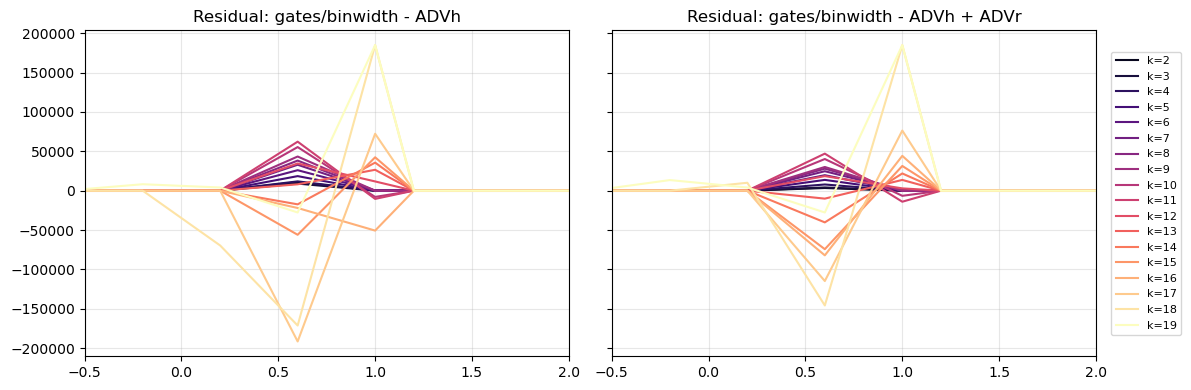

In [530]:
all_resids = np.full((19,nTm1),0)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)


# sequential colors (pick any: 'viridis', 'plasma', 'cividis', 'magma', 'Blues', ...)
cmap = plt.cm.magma
norm = mpl.colors.Normalize(vmin=1, vmax=19)

for izmax in range(2,20):
    color = cmap(norm(izmax))

    
    # redefine all the terms as a list from how we did before
    mymsk3d = np.zeros((nz,ny,nx))
    mymsk3d[izmax:izmax+1,iy,ix] = 1  # set the single point to mymsk3d
    mymsk3d[izmax:izmax+1,iyp1,ix] = 1
    mymsk3d[izmax:izmax+1,iy,ixp1] = 1
    mymsk3d[izmax:izmax+1,iyp1,ixp1] = 1
    
    
    # define the ADVh total for this mymsk2
    G_T_offline_new = np.zeros((7, nT-1))
    dF_Tnew = np.zeros((7, nT-1))
    Lijnew = np.zeros((7, nT-1), dtype=int)
    
    # also mask these by mymsk3
    # flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
    T_flat    = np.ravel(THETA* mymsk3d, order='F')
    ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
    ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
    DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
    DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
    surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
    kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
    tend_flat = np.ravel(tmptend* mymsk3d,  order='F')
    
    for i in range(nT-1):
        # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
        ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
        Lijnew[0, i] = len(ij)
    
        if len(ij) > 0:
            # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
            dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
            dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
            dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
            dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
            dF_Tnew[4, i] = np.nansum(surf_flat[ij])
            dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
            dF_Tnew[6, i] = np.nansum(tend_flat[ij])
    
    # MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
    G_T_offline_new = dF_Tnew / binwidthT1[None, :]

    # now do the gates one more time
    # great, now we get the gates again
    # allocate 3D "gate fields" (nan everywhere except the gate)
    M1T = np.full((nz, ny, nx), 0, dtype=float)  # south gate
    M2T = np.full((nz, ny, nx), 0, dtype=float)  # north gate
    M3T = np.full((nz, ny, nx), 0, dtype=float)  # east gate in
    M4T = np.full((nz, ny, nx), 0, dtype=float)  # west gate in
    MBT = np.full((nz, ny, nx), 0, dtype=float)  # bottom gate in -- should be of shape 2x2 and binned to those four values
    
    
    # the below makes no sense, write out what we want to read from
    ys,xs = np.array([iy,iy]),np.array([ix,ix+1])
    M1T[:izmax,ys,xs] += ADVy_TH[:izmax, ys, xs]
    
    yn,xn = np.array([iyp1+1,iyp1+1]),np.array([ix,ix+1])
    M2T[:izmax,yn-1,xn] -= ADVy_TH[:izmax, yn, xn]
    
    yw,xw = np.array([iy,iyp1]),np.array([ix,ix])
    M3T[:izmax,yw,xw] += ADVx_TH[:izmax,yw,xw]
    
    ye,xe = np.array([iy,iyp1]),np.array([ixp1+1,ixp1+1])
    M4T[:izmax,ye,xe-1] -= ADVx_TH[:izmax,ye,xe]

    # calculate the gates as nTm1 arrays
    G_S,G_N,G_E,G_W = gateway3D(M1T,M2T,M3T,M4T,THETA,binmidT,nTm1)  # in tracer.m^3/s
    G_S[np.isnan(G_S)] = 0
    G_N[np.isnan(G_N)] = 0
    G_W[np.isnan(G_W)] = 0
    G_E[np.isnan(G_E)] = 0

    gate_term = (G_S + G_W + G_E + G_N) / binwidthT1

    # (1) subtract only G_T_offline_new[0]
    resid_off0 = gate_term - G_T_offline_new[0]
    ax1.plot(boundsT.flatten()[1:-1], resid_off0,
             color=color, lw=1.5, linestyle='-',
             label=f"k={izmax}")

    # (2) subtract sumL (you define sumL; example: sum of selected offline terms)
    # e.g., if "sumL" means advh+advr:
    sumL = (G_T_offline_new[0] + G_T_offline_new[1])
    resid_sumL = gate_term - sumL
    ax2.plot(boundsT.flatten()[1:-1], resid_sumL,
             color=color, lw=1.5, linestyle='-',
             label=f"k={izmax}")

ax1.set_title("Residual: gates/binwidth - ADVh")
ax2.set_title("Residual: gates/binwidth - ADVh + ADVr")

for ax in (ax1, ax2):
    ax.set_xlim(-0.5, 2)
    ax.grid(True, alpha=0.3)

# optional colorbar keyed to k
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
# fig.colorbar(sm, ax=[ax1, ax2], pad=0.02, label="k (izmax)")

# optional: legend (usually too crowded with 19 lines)
ax2.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=8)

plt.tight_layout()
plt.show()

(-20.0, 0.0)

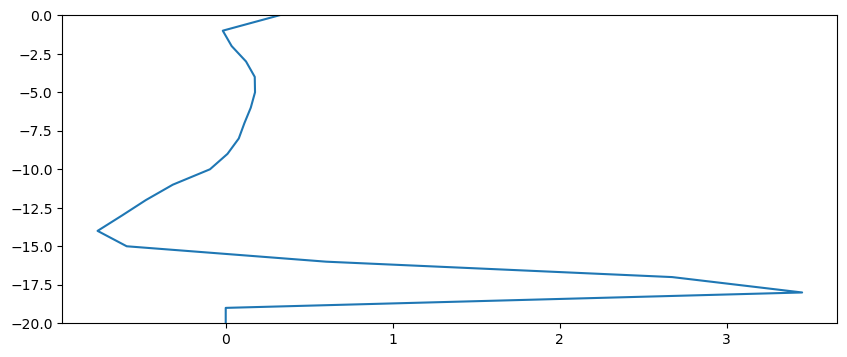

In [190]:
# what is the mean strength of ADVh as we go down?
meancol_ADVhT = np.nanmean(ADVhT * mymsk3d,axis=(1,2))
plt.plot(meancol_ADVhT,np.arange(0,-nz,-1))
plt.ylim(-20,0)

In [463]:
# try for subsea 2x2

In [573]:
# change this to the whole column
z = 17

# redefine all the terms as a list from how we did before
mymsk3d = np.zeros((nz,ny,nx))
mymsk3d[z,iy,ix] = 1  # set the single point to mymsk3d
mymsk3d[z,iyp1,ix] = 1
mymsk3d[z,iy,ixp1] = 1
mymsk3d[z,iyp1,ixp1] = 1


# define the ADVh total for this mymsk2
G_T_offline_new = np.zeros((7, nT-1))
dF_Tnew = np.zeros((7, nT-1))
Lijnew = np.zeros((7, nT-1), dtype=int)

# also mask these by mymsk3
# flatten the 3D arrays along all dimensions, as MATLAB’s tmp(:) does
T_flat    = np.ravel(THETA* mymsk3d, order='F')
ADVh_flat = np.ravel(ADVhT* mymsk3d,  order='F')
ADVr_flat = np.ravel(ADVrT* mymsk3d,  order='F')
DFh_flat = np.ravel(DFhT* mymsk3d,  order='F')
DFr_flat = np.ravel(DFrT* mymsk3d,  order='F')
surf_flat = np.ravel(Ft_surftest* mymsk3d,  order='F')
kpp_flat = np.ravel(tmpkpp* mymsk3d,  order='F')
tend_flat = np.ravel(tmptend* mymsk3d,  order='F')

for i in range(nT-1):
    # MATLAB: ij = find(tmp(:) >= bbb.binmidT(i) & tmp(:) < bbb.binmidT(i+1))
    ij = np.where((T_flat >= binmidT[i]) & (T_flat < binmidT[i + 1]))[0]
    Lijnew[0, i] = len(ij)

    if len(ij) > 0:
        # MATLAB: dF_Tnew(4,i)=sum(ff.advh(ij)); dF_Tnew(5,i)=sum(ff.advr(ij));
        dF_Tnew[0, i] = np.nansum(ADVh_flat[ij])
        dF_Tnew[1, i] = np.nansum(ADVr_flat[ij])
        dF_Tnew[2, i] = np.nansum(DFh_flat[ij])
        dF_Tnew[3, i] = np.nansum(DFr_flat[ij])
        dF_Tnew[4, i] = np.nansum(surf_flat[ij])
        dF_Tnew[5, i] = np.nansum(kpp_flat[ij])
        dF_Tnew[6, i] = np.nansum(tend_flat[ij])

# MATLAB: G_T_offline_new = dF_Tnew ./ repmat(bbb.binwidthT1,[6 1])
G_T_offline_new = dF_Tnew / binwidthT1[None, :]

In [574]:
# now do the gates one more time

# great, now we get the gates again
# allocate 3D "gate fields" (nan everywhere except the gate)
M1T = np.full((nz, ny, nx), 0, dtype=float)  # south gate
M2T = np.full((nz, ny, nx), 0, dtype=float)  # north gate
M3T = np.full((nz, ny, nx), 0, dtype=float)  # east gate in
M4T = np.full((nz, ny, nx), 0, dtype=float)  # west gate in
MBT = np.full((nz, ny, nx), 0, dtype=float)  # bottom gate in -- should be of shape 2x2 and binned to those four values


# the below makes no sense, write out what we want to read from
ys,xs = np.array([iy,iy]),np.array([ix,ix+1])
M1T[z,ys,xs] += ADVy_TH[z, ys, xs]

yn,xn = np.array([iyp1+1,iyp1+1]),np.array([ix,ix+1])
M2T[z,yn-1,xn] -= ADVy_TH[z, yn, xn]

yw,xw = np.array([iy,iyp1]),np.array([ix,ix])
M3T[z,yw,xw] += ADVx_TH[z,yw,xw]

ye,xe = np.array([iy,iyp1]),np.array([ixp1+1,ixp1+1])
M4T[z,ye,xe-1] -= ADVx_TH[z,ye,xe]

# we need to make one more gate which conains -ADVr_TH (not sure sign)
ybot,xbot = np.array([iy,iy,iyp1,iyp1]),np.array([ix,ixp1,ix,ixp1])
for j,i in zip(ybot,xbot):
    MBT[z-1,j,i] -= ADVr_TH[z,j,i]

In [575]:
G_S,G_N,G_E,G_W = gateway3D(M1T,M2T,M3T,M4T,THETA,binmidT,nTm1)  # in tracer.m^3/s
G_S[np.isnan(G_S)] = 0
G_N[np.isnan(G_N)] = 0
G_W[np.isnan(G_W)] = 0
G_E[np.isnan(G_E)] = 0

In [576]:
ADVhsum = (np.nansum(dF_Tnew[0]) / np.nansum(binwidthT1)) # m^3/s
G_S_sum = np.nansum(G_S) / np.nansum(binwidthT1)
G_N_sum = np.nansum(G_N) / np.nansum(binwidthT1)
G_E_sum = np.nansum(G_E) / np.nansum(binwidthT1)
G_W_sum = np.nansum(G_W) / np.nansum(binwidthT1)
print("ADVhT:",ADVhsum,"m^3/s")
print("gates sum:",G_S_sum+G_N_sum+ G_E_sum+ G_W_sum,"m^3/s")

# so these are the same

ADVhT: 773.5018287311829 m^3/s
gates sum: 773.5018287311831 m^3/s


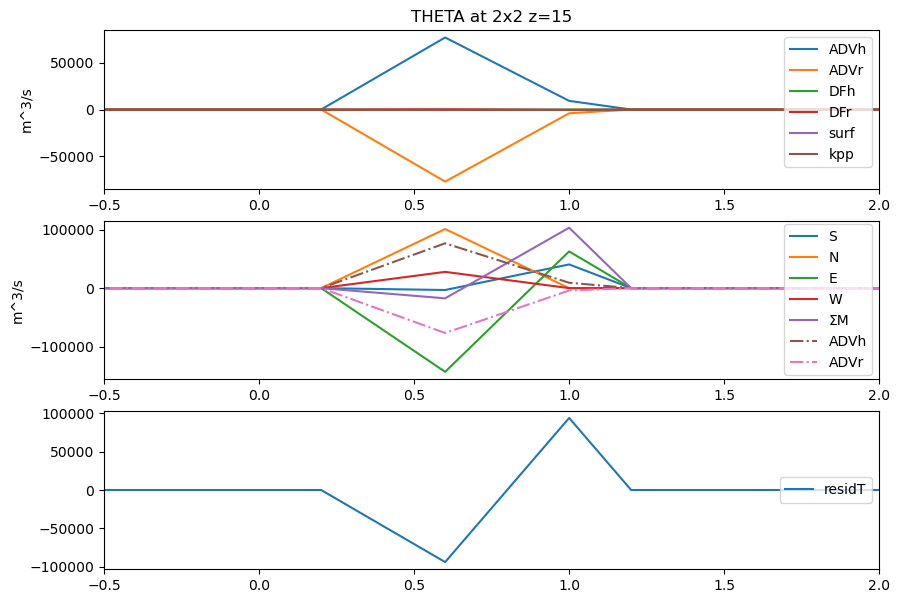

In [577]:
fig = plt.figure(figsize = (10,7))

ax = plt.subplot(311)
for i in range(6):
    ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[i],label = labels[i])

ax.legend()
ax.set_xlim(-.5,2)
v = THETA[:, iy, ix]  # column (nz,)
ax.set_title("THETA at 2x2 z=15")
ax.set_ylabel("m^3/s")


ax = plt.subplot(312)
ax.plot(boundsT.flatten()[1:-1],G_S/binwidthT1,label = labels_G[0])
ax.plot(boundsT.flatten()[1:-1],G_N/binwidthT1,label = labels_G[1])
ax.plot(boundsT.flatten()[1:-1],G_E/binwidthT1,label = labels_G[2])
ax.plot(boundsT.flatten()[1:-1],G_W/binwidthT1,label = labels_G[3])

ax.plot(boundsT.flatten()[1:-1],(G_S+G_W+G_E+G_N)/binwidthT1,label = labels_G[4])


# add the ADVh to this to compare
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-.")
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[1],label = labels[1],linestyle = "-.")

# ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0]+G_T_offline_new[1],label = "ADVr+ADVh",linestyle = "-.")

ax.legend(loc="right")
ax.set_xlim(-.5,2)
# ax.set_title(f"THETA at pt: {np.nanmin(v):.2f}–{np.nanmax(v):.2f}")
ax.set_ylabel("m^3/s")


ax = plt.subplot(313)
residT = (G_S+G_W+G_E+G_N)/binwidthT1 - G_T_offline_new[0]

ax.plot(boundsT.flatten()[1:-1],residT,label = "residT",linestyle = "-")
ax.set_xlim(-.5,2)
ax.legend(loc="right")

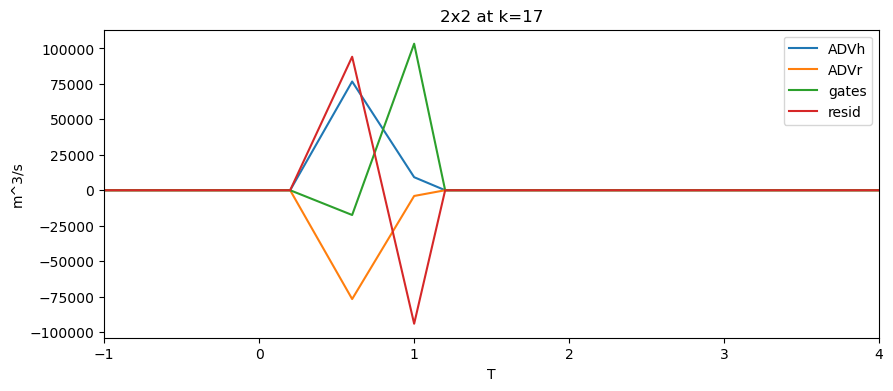

In [579]:
# can we look closer at the difference between these?

fig = plt.figure()

ax = plt.subplot(111)
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0],label = labels[0],linestyle = "-")
ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[1],label = labels[1],linestyle = "-")

ax.plot(boundsT.flatten()[1:-1],(G_S+G_W+G_E+G_N)/binwidthT1,label = "gates",linestyle = "-")

ax.plot(boundsT.flatten()[1:-1],G_T_offline_new[0] - (G_S+G_W+G_E+G_N)/binwidthT1,label = "resid",linestyle = "-")
ax.set_xlim(-1,4)
ax.set_title("2x2 at k=17")
ax.set_ylabel("m^3/s")
ax.set_xlabel("T")
ax.legend()

In [587]:
boundsT.flatten()[8:12]
c = 3678.0396602

array([0.2, 0.6, 1. , 1.2])

In [584]:
a = ADVhT*mymsk3d
a = a[17]
a[np.isnan(a)] = 0
print(a[a!=0])


a = THETA*mymsk3d
a[np.isnan(a)] = 0
b = a[a!=0]
print(b)

[ 3678.0396602  -9331.64863721 -8833.83098289 48830.92115556]
[0.82602531 0.43139371 0.77029496 0.79163963]


In [540]:
for z in range(19):

    # redefine all the terms as a list from how we did before
    mymsk3d = np.zeros((nz,ny,nx))
    mymsk3d[z,iy,ix] = 1  # set the single point to mymsk3d
    mymsk3d[z,iyp1,ix] = 1
    mymsk3d[z,iy,ixp1] = 1
    mymsk3d[z,iyp1,ixp1] = 1

    a = THETA/mygrid['hFacC']*mymsk3d
    a[np.isnan(a)] = 0
    b = a[a!=0]
    print(min(b),max(b),"at k=",str(z))

0.7088754177093506 0.7656659483909607 at k= 0
0.7124682068824768 0.7701917886734009 at k= 1
0.7149781584739685 0.7723485231399536 at k= 2
0.7172092199325562 0.7734972834587097 at k= 3
0.7196075320243835 0.774120032787323 at k= 4
0.7226251363754272 0.774509608745575 at k= 5
0.7269571423530579 0.7748719453811646 at k= 6
0.7341670989990234 0.7753440141677856 at k= 7
0.7465491890907288 0.7759946584701538 at k= 8
0.7637807130813599 0.7810964584350586 at k= 9
0.763380229473114 0.8064181208610535 at k= 10
0.7631600499153137 0.8278915286064148 at k= 11
0.7632769346237183 0.8531234860420227 at k= 12
0.7641293406486511 0.867155909538269 at k= 13
0.7670218348503113 0.8844623565673828 at k= 14
0.7783894538879395 0.9044029712677002 at k= 15
0.7194551229476929 0.8988825678825378 at k= 16
0.43139371275901794 0.8260253071784973 at k= 17
0.2581312954425812 0.7699161171913147 at k= 18


## Propose an alternative using UVELMASS and VVELMASS at the gates

We already know these are about the same as doing ADV/face theta (shown in previous notebooks)

In [93]:
# Load the UVELMASS and VVELMASS terms
ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
ADVr_TH = ADVr_TH.reshape((nz,ny,nx))

DFxE_TH = DFxE_TH.reshape((nz,ny,nx))
DFyE_TH = DFyE_TH.reshape((nz,ny,nx))
DFrE_TH = DFrE_TH.reshape((nz,ny,nx))

KPPg_TH = KPPg_TH.reshape((nz,ny,nx))

UVELMASS = UVELMASS.reshape((nz,ny,nx))
VVELMASS = VVELMASS.reshape((nz,ny,nx))

Ft_surftest.shape

(50, 450, 90)

In [94]:
print(iy,ix)

170 5


In [88]:
# load the THETADR at the snaps

In [92]:
t2 = int(tsstr[1])

THETA = np.zeros((len(tsstr),nz,ny,nx))
SALT = np.zeros((len(tsstr),nz,ny,nx))

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

for i in range(len(tsstr)):
    t2 = int(tsstr[i])
    THETAi,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
    SALTi,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

    THETAi = THETAi.reshape(nz,ny,nx)
    SALTi = SALTi.reshape(nz,ny,nx)

    THETA[i] = THETAi
    SALT[i] = SALTi

In [96]:
dt = 86400

In [103]:
boundsT.shape

(113, 1, 1)

In [111]:
THETA_n = THETA[0]
THETA_np1 = THETA[1]
DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))
RAC3d = np.tile(mygrid['RAC'][np.newaxis,:,:],(nz,1,1))
hFacC = mygrid['hFacC']
V = DRF3d * RAC3d * hFacC

# ---------------------------
# Inputs you have
# ---------------------------
# THETA_n, THETA_np1: snapshots at t^n and t^{n+1}, shape (nz,ny,nx), degC
# DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH: shape (nz,ny,nx), degC*m^3/s (cell-centered)
# Ft_surftest: shape (nz,ny,nx), degC*m^3/s (cell-centered)
# UVELMASS, VVELMASS: for gates, either m^3/s (transport) OR m/s (velocity)
# binmidT: shape (nT,), bin midpoints (degC)
# dt: seconds between snapshots
# V: cell volume (m^3), shape (nz,ny,nx) = drF*RAC*hFacC

# ---------------------------
# 1) Build bin edges from binmidT
# ---------------------------
def edges_from_midpoints(mid):
    mid = np.asarray(mid)
    # interior edges are midpoints between mids
    edges = np.empty(mid.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (mid[:-1] + mid[1:])
    # extrapolate outer edges
    edges[0]  = mid[0]  - (edges[1] - mid[0])
    edges[-1] = mid[-1] + (mid[-1] - edges[-2])
    return edges

binEdgesT = edges_from_midpoints(boundsT.flatten()[1:-1])   # length = nT+1

def bin_index(theta, edges):
    edges = np.asarray(edges)
    # validate once
    if edges.ndim != 1 or not np.all(np.diff(edges) > 0):
        raise ValueError("edges must be 1D and strictly increasing.")

    nb = len(edges) - 1

    # clip into [edges[0], nextafter(edges[-1], -inf)]
    hi = np.nextafter(edges[-1], -np.inf)
    theta_clip = np.clip(theta, edges[0], hi)

    idx = np.digitize(theta_clip, edges, right=False) - 1  # 0..nb-1
    # idx should now be safe, but keep hard guard:
    idx[(idx < 0) | (idx >= nb)] = -1
    return idx


# ---------------------------
# 2) Define a small region around (y=170,x=5)
#    (choose a neighborhood; here +/-1 in each direction)
# ---------------------------
def region_mask(nz, ny, nx, y0=170, x0=5, dy=1, dx=1):
    m2 = np.zeros((ny, nx), dtype=bool)
    ys = slice(max(0, y0-dy), min(ny, y0+dy+1))
    xs = slice(max(0, x0-dx), min(nx, x0+dx+1))
    m2[ys, xs] = True
    m3 = np.broadcast_to(m2, (nz, ny, nx)).copy()
    return m2, m3

m2, m3 = region_mask(nz, ny, nx, y0=170, x0=5, dy=1, dx=1)

# ---------------------------
# 3) Gate exchange spectrum G_k (m^3/s per theta bin)
#    computed on the perimeter of the masked region.
#
#    This version assumes UVELMASS and VVELMASS are on C-cells as "through-cell" values
#    (your reshape to (nz,ny,nx) suggests that), so we treat:
#      UVELMASS[k,j,i] = transport across the EAST face of cell (i,j) (or similar).
#    If your UVELMASS/VVELMASS are actually on faces with nx+1/ny+1, adjust indexing accordingly.
# ---------------------------

def gate_exchange_from_UV_on_Cgrid(
    THETA, U, Vv, mask2, edges, U_is_transport=True,
    face_area_U=None, face_area_V=None,
):
    """
    THETA: (nz,ny,nx) degC
    U:     (nz,ny,nx) either transport (m^3/s) or velocity (m/s)
    Vv:    (nz,ny,nx) same
    mask2: (ny,nx) bool region
    edges: bin edges
    If U_is_transport=False, provide face_area_U, face_area_V in m^2 so Q=U*Area.
    Returns G (nBins,) m^3/s into region, binned by upwind theta.
    """
    nz, ny, nx = THETA.shape
    print(len(edges))
    nb = len(edges) - 1
    print(nb)
    G = np.zeros(nb, dtype=float)

    # helper to add contributions
    def add_flux(Q_into, theta_up):
        b = bin_index(theta_up, edges)
        ok = (b >= 0) & np.isfinite(Q_into) & np.isfinite(theta_up)
        np.add.at(G, b[ok], Q_into[ok])

    # Convert to transports if needed
    if not U_is_transport:
        if face_area_U is None or face_area_V is None:
            raise ValueError("Need face_area_U/face_area_V if U,V are velocities (m/s).")
        UQ = U * face_area_U  # m^3/s
        VQ = Vv * face_area_V
    else:
        UQ = U
        VQ = Vv

    # Iterate over boundary faces of mask2.
    # Convention here (you must match your diagnostic):
    # - UQ[...,j,i] is transport from cell (i,j) to (i+1,j) when positive.
    # - VQ[...,j,i] is transport from cell (i,j) to (i,j+1) when positive.

    for j in range(ny):
        for i in range(nx):
            if not mask2[j, i]:
                continue

            # EAST face: neighbor at (i+1,j) outside mask => gate face
            if i+1 < nx and (not mask2[j, i+1]):
                Q = UQ[:, j, i]  # positive means out of cell to the east
                # Into region is negative Q (flow from outside->inside across east face)
                # Upwind theta: if Q<0, upstream is east neighbor; else upstream is inside cell.
                theta_in  = THETA[:, j, i]
                theta_out = THETA[:, j, i+1]
                theta_up = np.where(Q < 0, theta_out, theta_in)
                Q_into = -Q
                add_flux(Q_into, theta_up)

            # WEST face: neighbor at (i-1,j) outside mask
            if i-1 >= 0 and (not mask2[j, i-1]):
                # transport across west face is stored on neighbor cell (i-1) east face in this convention
                Q = UQ[:, j, i-1]  # positive means from (i-1)->(i) into region
                theta_out = THETA[:, j, i-1]
                theta_in  = THETA[:, j, i]
                theta_up = np.where(Q > 0, theta_out, theta_in)
                Q_into = Q
                add_flux(Q_into, theta_up)

            # NORTH face: neighbor at (i,j+1) outside mask
            if j+1 < ny and (not mask2[j+1, i]):
                Q = VQ[:, j, i]  # positive means out of cell to the north
                theta_in  = THETA[:, j, i]
                theta_out = THETA[:, j+1, i]
                theta_up = np.where(Q < 0, theta_out, theta_in)
                Q_into = -Q
                add_flux(Q_into, theta_up)

            # SOUTH face: neighbor at (i,j-1) outside mask
            if j-1 >= 0 and (not mask2[j-1, i]):
                Q = VQ[:, j-1, i]  # positive means from (i,j-1)->(i,j) into region
                theta_out = THETA[:, j-1, i]
                theta_in  = THETA[:, j, i]
                theta_up = np.where(Q > 0, theta_out, theta_in)
                Q_into = Q
                add_flux(Q_into, theta_up)

    return G

# Example call:
# Set this correctly:
U_is_transport = True  # set False if your "UVELMASS" is actually m/s
UVol = UVELMASS * np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
VVol = VVELMASS * np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))

G_k = gate_exchange_from_UV_on_Cgrid(THETA_n, UVol, VVol, m2, binEdgesT, U_is_transport=U_is_transport)

# ---------------------------
# 4) Internal mixing + surface forcing as conservative bin-to-bin transfers
# ---------------------------
def wmt_transfer_from_diabatic_terms(
    THETA, V, dt, edges, mask3d,
    DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH, Ft_surf
):
    """
    All diabatic terms are cell-centered in degC*m^3/s.
    Returns:
      D_all: (nBins,) m^3/s per theta bin (net diabatic transformation)
      D_mix: mixing-only (DF + KPP)
      D_surf: surface-only
    """
    nb = len(edges) - 1

    # Build tendencies (degC/s)
    DF_term  = DFxE_TH + DFyE_TH + DFrE_TH          # degC*m^3/s
    MIX_term = DF_term + KPPg_TH                    # degC*m^3/s
    SURF_term = Ft_surf                             # degC*m^3/s

    dtheta_dt_mix  = (MIX_term  / V)
    dtheta_dt_surf = (SURF_term / V)
    dtheta_dt_all  = dtheta_dt_mix + dtheta_dt_surf

    # Predict theta* for each contribution separately
    theta_star_mix  = THETA + dtheta_dt_mix  * dt
    theta_star_surf = THETA + dtheta_dt_surf * dt
    theta_star_all  = THETA + dtheta_dt_all  * dt

    def bin_to_bin(theta0, theta1):
        oldb = bin_index(theta0, edges)
        newb = bin_index(theta1, edges)
    
        valid = (oldb >= 0) & (newb >= 0)
        moved = valid & (newb != oldb) & (mask3d > 0)
    
        trans = (V / dt) * mask3d  # m^3/s
    
        D = np.zeros(nb, dtype=float)
    
        # Safety: mask out any residual bad indices (should be none now)
        moved &= (oldb < nb) & (newb < nb)
    
        np.add.at(D, oldb[moved], -trans[moved])
        np.add.at(D, newb[moved], +trans[moved])
        return D


    D_mix  = bin_to_bin(THETA, theta_star_mix)
    D_surf = bin_to_bin(THETA, theta_star_surf)
    D_all  = bin_to_bin(THETA, theta_star_all)

    return D_all, D_mix, D_surf

D_all, D_mix, D_surf = wmt_transfer_from_diabatic_terms(
    THETA_n, V, dt, binEdgesT, m3.astype(float),
    DFxE_TH, DFyE_TH, DFrE_TH, KPPg_TH, Ft_surftest
)

# ---------------------------
# 5) Optional: snapshot volume tendency per bin (LHS)
# ---------------------------
def bin_volume(theta, V, edges, mask3d=None):
    nb = len(edges) - 1
    if mask3d is None:
        mask3d = 1.0
    b = bin_index(theta, edges)
    Vk = np.zeros(nb, dtype=float)
    ok = (b >= 0) & (mask3d > 0)
    np.add.at(Vk, b[ok], (V * mask3d)[ok])
    return Vk

Vk_n   = bin_volume(THETA_n,   V, binEdgesT, mask3d=m3.astype(float))
Vk_np1 = bin_volume(THETA_np1, V, binEdgesT, mask3d=m3.astype(float))
dVk_dt = (Vk_np1 - Vk_n) / dt  # m^3/s per bin

# ---------------------------
# 6) Closure check (per bin)
# ---------------------------
# For a WMT-style budget in this region:
#   dV/dt ≈ gate_exchange + diabatic_transformation + residual
residual = dVk_dt - (G_k + D_all)

print("sum(dVk_dt) [m^3/s] =", np.nansum(dVk_dt))
print("sum(G_k)    [m^3/s] =", G_k.sum())
print("sum(D_all)  [m^3/s] =", D_all.sum(), " (should be ~0)")
print("sum(resid)  [m^3/s] =", np.nansum(residual))# .sum(), " (should be small if everything is consistent)")


112
111
sum(dVk_dt) [m^3/s] = 0.0
sum(G_k)    [m^3/s] = -58733.59049226724
sum(D_all)  [m^3/s] = 0.0  (should be ~0)
sum(resid)  [m^3/s] = 57872.15209191605


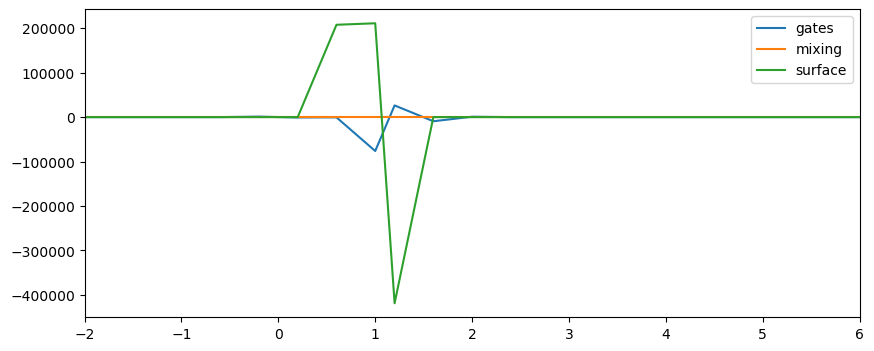

In [120]:
fig = plt.figure()

ax = plt.subplot(111)

ax.plot(boundsT.flatten()[1:-1],G_k,label="gates")
ax.plot(boundsT.flatten()[1:-1],D_mix,label="mixing")
ax.plot(boundsT.flatten()[1:-1],D_surf,label="surface")

ax.set_xlim(-2,6)
ax.legend()

In [ ]:
# this really does not make sense to me.

## Let's return to the Walin way of thinking about this

In [122]:
# ADVx_TH = ADVx_TH.reshape((nz,ny,nx))
# ADVy_TH = ADVy_TH.reshape((nz,ny,nx))
# ADVr_TH = ADVr_TH.reshape((nz,ny,nx))

# DFxE_TH = DFxE_TH.reshape((nz,ny,nx))
# DFyE_TH = DFyE_TH.reshape((nz,ny,nx))
# DFrE_TH = DFrE_TH.reshape((nz,ny,nx))

# KPPg_TH = KPPg_TH.reshape((nz,ny,nx))

# UVELMASS = UVELMASS.reshape((nz,ny,nx))
# VVELMASS = VVELMASS.reshape((nz,ny,nx))

# Ft_surftest.shape

In [147]:
# I think we only want the DF terms where DF is moving between different bins of TH
# that would be a water mass transformation across an isothermal surface

In [152]:
# DFrE_TH[0][iy,ix]  # defined as down into the next bin

In [160]:
# THETA_n

In [174]:
col = THETA_n[:, iy, ix]          # (nz,)
col_np1 = THETA_np1[:, iy, ix]          # (nz,)

edges = np.asarray(binmidT)       # treat binmidT as edges (must be increasing)

hi = np.nextafter(edges[-1], -np.inf)

def get_col(col,edges):
    bidx_n = np.digitize(np.clip(col, edges[0], hi), edges) - 1  # 0..len(edges)-2
    bidx_n[(bidx_n < 0) | (bidx_n >= len(edges)-1)] = -1
    return bidx_n

bidx_n = get_col(col,edges)

bidx_n_xp1 = get_col(THETA_n[:,iy,ix+1],edges)
bidx_n_xm1 = get_col(THETA_n[:,iy,ix-1],edges)
bidx_n_yp1 = get_col(THETA_n[:,iy+1,ix],edges)
bidx_n_ym1 = get_col(THETA_n[:,iy-1,ix],edges)

# bidx_np1 = np.digitize(np.clip(col_np1, edges[0], hi), edges) - 1  # 0..len(edges)-2
# bidx_np1[(bidx_np1 < 0) | (bidx_np1 >= len(edges)-1)] = -1

# difference here is zero so possibly not useful

In [176]:
rightdiff = (bidx_n_xp1-bidx_n)  # where we want -DX at x+1
leftdiff = (bidx_n_xm1-bidx_n)   # where we want +DX at x
topdiff = (bidx_n_yp1-bidx_n)    # where we want -DY at y+1
botdiff = bidx_n_ym1 - bidx_n    # where we want +DY at y

In [196]:
dF_Tnew = np.zeros((8,nT-1))

for k in range(nz):
    iT = bidx_n[k]
    
    # do the gates first
    dF_Tnew[0,iT] += ADVx_TH[k,iy,ix]
    dF_Tnew[1,iT] -= ADVx_TH[k,iy,ix+1]
    dF_Tnew[2,iT] += ADVy_TH[k,iy,ix]
    dF_Tnew[3,iT] -= ADVx_TH[k,iy+1,ix]

    # we still need DFx and DFy, for this we need the indices of the surrounding bins
    if rightdiff[k] != 0:
        dF_Tnew[6,iT] -= DFxE_TH[k,iy,ix+1]
    if leftdiff[k] != 0:
        dF_Tnew[6,iT] += DFxE_TH[k,iy,ix]

    if topdiff[k] != 0:
        dF_Tnew[6,iT] -= DFyE_TH[k,iy+1,ix]
    if leftdiff[k] != 0:
        dF_Tnew[6,iT] += DFyE_TH[k,iy,ix]

for k in range(1,nz):
    iT = bidx_n[k]

    # for vertical terms, test if the value down is not the same T bin, if not, add this value
    # then it is a transformation
    if bidx_n[k] != bidx_n[k-1]:
        dF_Tnew[4,iT] += KPPg_TH[k,iy,ix]
        dF_Tnew[5,iT] += DFrE_TH[k,iy,ix]
        #dF_Tnew[6,iT] += ADVr_TH[k,iy,ix]

for k in range(nz):
    iT = bidx_n[k]
    
    dF_Tnew[7,iT] += Ft_surftest[k,iy,ix]


labels = np.array(["W","E","S","N","KPP","DFr","DFh","surf","sum"])

(-2.0, 5.0)

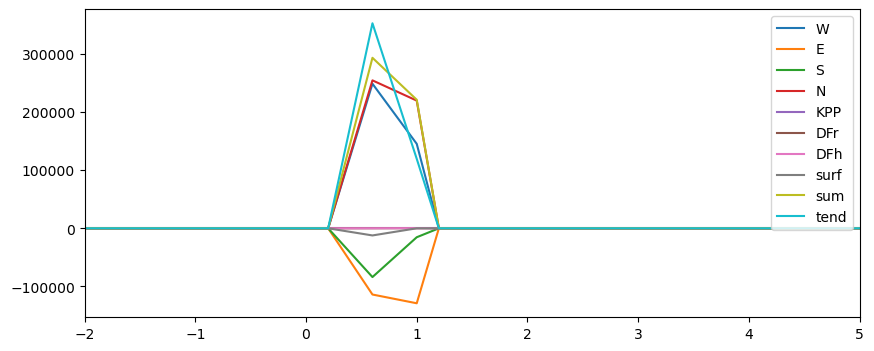

In [204]:
fig = plt.figure()

ax = plt.subplot(111)

for i in range(8):
    ax.plot(boundsT.flatten()[1:-1],dF_Tnew[i],label = labels[i])
sumterms = np.nansum(dF_Tnew,axis=0)
ax.plot(boundsT.flatten()[1:-1],sumterms,label = labels[-1])
ax.plot(boundsT.flatten()[1:-1],tend_T/2e2,label="tend")
ax.legend()
ax.set_xlim(-2,5)

In [187]:
tend_col = tmptend[:,iy,ix]

In [192]:
tend_T = np.zeros(nT-1)
tend_T

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [193]:
for k in range(nz):
    iT = bidx_n[k]
    tend_T[iT] += tend_col[k]

In [194]:
tend_T

array([       0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        , 70607559.05879346,
       23924448.1149643 ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.        ,        0.        ,
              0.        ,        0.     